In [1]:
import math
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(14) #MODIFY IF NEEDED

# Neural Network Functions

In [2]:
class Neuron:
    def __init__(self, n_type, num_weights=0, learning_rate=0.1):
        self.n_type = n_type
        self.prev_weights = np.ones(num_weights)
        self.weights = np.random.random_sample(num_weights) #array of random weights
        self.activation_value = 0
        self.learning_rate = learning_rate
        self.current_values = np.ones(num_weights) #temporary values as the move across the nn
        
    def sigmoid(self, value):
        return 1 / (1 + math.exp(-value))
        
    def value_x_weight(self, value):
        "multiply a recieved value by each weight path that a neuron has, and hold that value"
        self.current_values = self.weights * value
            
    def value_x_activation(self, sum_weights):
        """activation function, recieves the sum of weights, activitaes it, then stores the value"""
        self.activation_value = self.sigmoid(sum_weights)
            
    def update_weight_hl(self, weight_num, output, target_out):
        """perfrm gradient decent to calcualte the next weight, return certain part of the chain as we can reuse it in the next later"""
        # new weight = old weight * learning rate  * partial derivative cost * partial derivative sigmoid: output * partial derivative sum: hidden neuron activation value
        self.prev_weights[weight_num] = self.weights[weight_num]
        self.weights[weight_num] = self.weights[weight_num] + self.learning_rate * (target_out - output) * (output * (1 - output)) * (self.activation_value)
        
    def update_weight_il(self, weight_num, output_list, nn_des_out, previous_w, hl_act, nn_input):
        """perfrm gradient decent to calcualte the next weight, this is an extended chain rule that calculates 2 weight deltas to add them up"""
        c = 0
        for output, des_out, prev_w, nni  in zip(output_list, nn_des_out, previous_w, nn_input):
            c += output * (1 - output) * (des_out - output) * prev_w * hl_act * (1 - hl_act) * nni
        self.weights[weight_num] = self.weights[weight_num] + self.learning_rate * (c)

    def __str__(self):
        return f"{self.n_type} | Weights: {self.weights} | Activation_V: {self.activation_value}"
        
def print_all(il,hl,ol):
    print(" ")
    for i in il:
        print(i)
    for i in hl:
        print(i)
    for i in ol:
        print(i)
    print(" ")
        

In [3]:
def create_nn(num_of_neurons_il = 2, num_of_neurons_hl = 3, num_of_neurons_ol = 2, learning_rate=0.3):
    """function to create a neural network with any # of neoron on each layer, input layer (il)
    # of neurons in  hidden layer (hl) = number of weights (il)<->(hl)
    # of neurons in the output layer (ol) = number of weights (hl)<->(ol)"""
    
    input_layer, hidden_layer, output_layer = [], [], []
    
    for i in range(num_of_neurons_il): # create the neurons and weights
        input_layer.append(Neuron(n_type = "input", num_weights=num_of_neurons_hl, learning_rate = learning_rate))

    for i in range(num_of_neurons_hl): # create the neurons and weights
        hidden_layer.append(Neuron(n_type = "hidden", num_weights=num_of_neurons_ol, learning_rate = learning_rate))

    for i in range(num_of_neurons_ol): # create the neurons
        output_layer.append(Neuron(n_type = "output", learning_rate = learning_rate))
    
    return input_layer, hidden_layer, output_layer


In [4]:
def forward_prop(nn_input, input_layer, hidden_layer, output_layer):
    """ forward propagation functon, makes the input travel trough the whole NN"""
    for i, j in enumerate(nn_input):
        input_layer[i].value_x_weight(j)
        
    for hl_neuron, i in zip(hidden_layer, range(len(hidden_layer))): # I THINK THIS COULD HAVE BEEN DONE WITH AN ENUMERATE
        sum_of_values = 0
        for j in input_layer:
            sum_of_values += j.current_values[i] #sum of the (il)weights that will go into the (hl)neuron 
        hl_neuron.value_x_activation(sum_of_values) #activiation
        hl_neuron.value_x_weight(hl_neuron.activation_value) #multiply the activation result by the next weights (hl)
    
    for ol_neuron, i in zip(output_layer, range(len(output_layer))):
        sum_of_values = 0
        for j in hidden_layer:
            sum_of_values += j.current_values[i] #sum of the weights that will go into the neuron
        ol_neuron.value_x_activation(sum_of_values) #activation function "linear"

    return input_layer, hidden_layer, output_layer


In [5]:
def backward_prop(nn_input, nn_des_out, input_layer, hidden_layer, output_layer):
    """Backward propagation based on the chain rule"""
    output_list = []

    for i, ol_neuron in enumerate(output_layer): # "i" matches the corresponding weights that go into that neuron, 
        output = ol_neuron.activation_value
        output_list.append(output)
        for hl_neuron in hidden_layer:
            hl_neuron.update_weight_hl(i, output, nn_des_out.iloc[i])

    w_count = 0
    for i, il_neuron in enumerate(input_layer):
        for j, hl_neuron in enumerate(hidden_layer):
            il_neuron.update_weight_il(j, output_list, nn_des_out, hl_neuron.prev_weights, hl_neuron.activation_value, nn_input)
            w_count+=1
    
    return input_layer, hidden_layer, output_layer

In [6]:
def calculate_accuracy(test_scaled, samples_num, margin, il, hl, ol, cross_val):
    """ function to calculate the accuracy of the model with random test dataset samples, this is the stopping criteria, evaluates accuracy by neuron and total.
    By total accuracy we evaluate is both outputs of each neuron compared to the target have a minimal error"""
    accuracy_list1, accuracy_list2, accuracy_list3 = [], [], []
    for i in range(cross_val):

        random_sample = test_scaled.sample(n=samples_num)
        accuracy_count1, accuracy_count2, accuracy_count3 = 0, 0, 0

        for index, row in random_sample.iterrows():
            nn_input, desired_out = row[0:2], row[2:4]
            il, hl, ol = forward_prop(nn_input, il, hl, ol)

            if (abs((desired_out.iloc[0] - ol[0].activation_value)) + abs((desired_out.iloc[1] - ol[1].activation_value)))/ 2 <= margin: # total, if both errors are minimal
                accuracy_count1 +=1

            if abs((desired_out.iloc[0] - ol[0].activation_value)) <= margin: # output neuron 1
                accuracy_count2 +=1

            if abs((desired_out.iloc[1] - ol[1].activation_value)) <= margin: # output neuron 2
                accuracy_count3 +=1

        accuracy_list1.append((accuracy_count1 / samples_num) * 100)
        accuracy_list2.append((accuracy_count2 / samples_num) * 100)
        accuracy_list3.append((accuracy_count3 / samples_num) * 100)
            
    return [sum(accuracy_list1) / cross_val, sum(accuracy_list2) / cross_val, sum(accuracy_list3) / cross_val]


In [7]:
def create_weights_array(il,hl,ol):
    """ function to save the weights of the trained NN to a .txt file to be loaded up in the game"""
    weights_list = []
    for i in il,hl,ol:
        for j in i:
            weights_list.append(j.weights)
            
    with open("weights.txt", 'w') as file:
        for array in weights_list:
            # Convert each array to a string and write it to the file
            array_str = ' '.join(map(str, array))
            file.write(array_str + '\n')
            
def load_weights_array(file, il, hl, ol):
    """function to be able to load the txt file with the weights into the layers of the network"""
    weights = []
    with open(file, 'r') as file:
        for line in file:
            # Read each line from the file, split it into values, and convert them back to an array
            array = np.array(list(map(float, line.strip().split())))
            weights.append(array)

    counter = 0
    for i in il,hl,ol:
        for j in i:
            j.weights = weights[counter]
            counter += 1

    return il, hl, ol

# Preprocessing the data

In [8]:
def prep_data(file):  
    """standard data preprocessing function"""
    
    column_names = ['X_dtt', 'Y_dtt', 'X_vel', 'Y_vel'] 
    #dtt = distance to target (distance in pixels to the target), vel = velocity (Pixels per second)
    df = pd.read_csv(file, names=column_names)

    test_size = 0.08 #Splitting into training and test sets
    n_samples = len(df)

    test_indices = np.random.choice(df.index, size=int(n_samples * test_size), replace=False) #cretae random row indices to be able to split the dat ainto training and testing

    test = df.loc[test_indices] # Using the test indices to select rows for the test set
    train = df.drop(test_indices) # Use the remaining indices for the training set

    #Scaling the data
    # Calculate the minimum and maximum values for each column in the training set and the test set 
    test_min_values = test.min(axis=0)
    test_max_values = test.max(axis=0)

    train_min_values = train.min(axis=0)
    train_max_values = train.max(axis=0)

    # Perform Min-Max scaling on the training and testing sets
    test_scaled = (test - test_min_values) / (test_max_values - test_min_values)
    train_scaled = (train - train_min_values) / (train_max_values - train_min_values)

    return train_scaled, test_scaled


In [9]:
train_scaled , test_scaled = prep_data("Datav2.csv")

# Training the Neural Network

Epoch: 0 | Accuracy = Total: 10.2 Neuron 1: 26.7 Neuron 2: 17.1
Epoch: 1 | Accuracy = Total: 10.0 Neuron 1: 32.0 Neuron 2: 16.7
Epoch: 2 | Accuracy = Total: 14.3 Neuron 1: 31.9 Neuron 2: 19.2
Epoch: 3 | Accuracy = Total: 18.6 Neuron 1: 31.9 Neuron 2: 22.7
Epoch: 4 | Accuracy = Total: 17.5 Neuron 1: 31.2 Neuron 2: 30.3
Epoch: 5 | Accuracy = Total: 21.7 Neuron 1: 28.5 Neuron 2: 40.2
Epoch: 6 | Accuracy = Total: 23.8 Neuron 1: 35.2 Neuron 2: 45.8
Epoch: 7 | Accuracy = Total: 25.8 Neuron 1: 30.2 Neuron 2: 50.0
Epoch: 8 | Accuracy = Total: 24.8 Neuron 1: 32.4 Neuron 2: 47.9
Epoch: 9 | Accuracy = Total: 27.6 Neuron 1: 30.3 Neuron 2: 48.9
Epoch: 10 | Accuracy = Total: 25.7 Neuron 1: 31.2 Neuron 2: 46.1
Epoch: 11 | Accuracy = Total: 25.2 Neuron 1: 33.7 Neuron 2: 44.6
Epoch: 12 | Accuracy = Total: 20.0 Neuron 1: 33.2 Neuron 2: 39.2
Epoch: 13 | Accuracy = Total: 19.6 Neuron 1: 31.1 Neuron 2: 29.9
Epoch: 14 | Accuracy = Total: 17.3 Neuron 1: 32.4 Neuron 2: 24.6
Epoch: 15 | Accuracy = Total: 17.0 

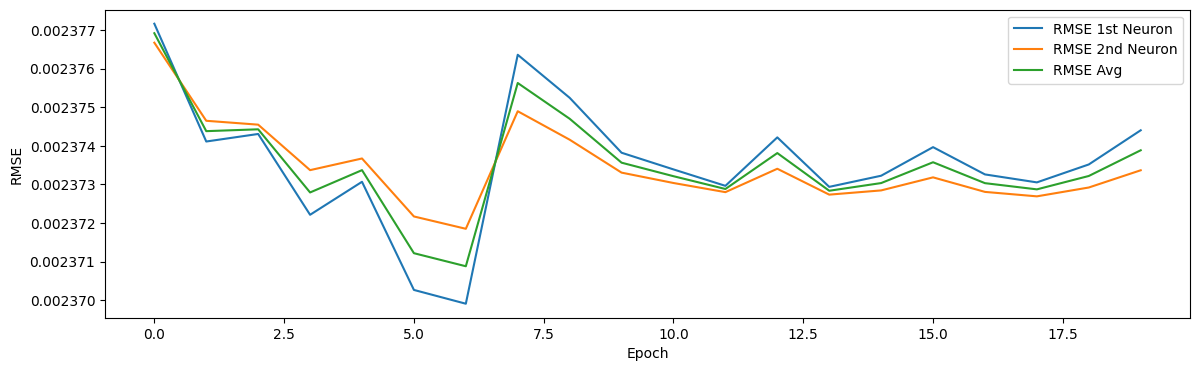

 
input | Weights: [-0.58113612 -0.22312496 -0.52821375 -0.02175824 -0.15647674 -0.07043685
 -0.47152158  7.54128242] | Activation_V: 0
input | Weights: [ 0.01589776 -0.06408369 -0.05882019  0.19438531 -0.05158489  0.20739776
 -0.03894874  7.49364364] | Activation_V: 0
hidden | Weights: [-1.95862357 -7.85898652] | Activation_V: 0.47128929356212573
hidden | Weights: [ 0.3538027  -1.47267207] | Activation_V: 0.47469205668449566
hidden | Weights: [-1.43420406 -6.0781356 ] | Activation_V: 0.45904524147560116
hidden | Weights: [-0.58431974 -1.77102063] | Activation_V: 0.5383150151855728
hidden | Weights: [ 0.42551099 -0.13587364] | Activation_V: 0.4808928283076947
hidden | Weights: [-1.03019704 -2.50264076] | Activation_V: 0.5382864512360412
hidden | Weights: [-1.38667473 -4.84247344] | Activation_V: 0.4661717445811576
hidden | Weights: [ 2.47604168 11.28374508] | Activation_V: 0.9995756287452712
output | Weights: [] | Activation_V: 0.4379718691085874
output | Weights: [] | Activation_V: 0.

In [10]:
hl_num = 8
lr = 0.6
epochs = 20
rows = 50000

il, hl, ol = create_nn(2,hl_num,2,lr) #(il) , (hl), (ol)

error1, error2, output1, output2, rmse1, rmse2, rmse3 = [], [], [], [], [], [], []

for i in range(epochs): #epochs
    error1, output1, eror2, output2 = [], [], [], []
    
    for index, row in train_scaled[:rows].iterrows():
        nn_input, desired_out = row[0:2], row[2:4]
        il, hl, ol = forward_prop(nn_input, il, hl, ol)
        error1.append(desired_out.iloc[0] - ol[0].activation_value)
        error2.append(desired_out.iloc[1] - ol[1].activation_value)
        output1.append(ol[0].activation_value)
        output2.append(ol[0].activation_value)
        il, hl, ol = backward_prop(nn_input, desired_out, il, hl, ol)

    one = math.sqrt(((sum(error1)/len(error1)) - (sum(output1)/len(output1)))**2 / len(error1))
    rmse1.append(one)
    two = math.sqrt(((sum(error2)/len(error2)) - (sum(output2)/len(output2)))**2 / len(error1))
    rmse2.append(two)
    rmse3.append((one + two) / 2)

    acc = calculate_accuracy(test_scaled, 100, .05, il, hl, ol, 10)
    print(f"Epoch: {i} | Accuracy = Total: {acc[0]} Neuron 1: {acc[1]} Neuron 2: {acc[2]}")
    if float(acc[0]) > 29.5: # set the accuracy you want to achieve
         print("- - - - - Training Finished - - - - -")
         break

print(f"\n Numer of hidden neurons: {hl_num} | Learning rate: {lr} | Epochs: {epochs} | Number of Rows: {rows}" )
plt.figure(figsize=(14, 4))
plt.plot(rmse1, label='RMSE 1st Neuron')
plt.plot(rmse2, label='RMSE 2nd Neuron')
plt.plot(rmse3, label='RMSE Avg')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

print_all(il,hl,ol)

create_weights_array(il,hl,ol) # create the weights file


# Testing the Neural Network

Validation test set RMSE: 0.03518397833034019


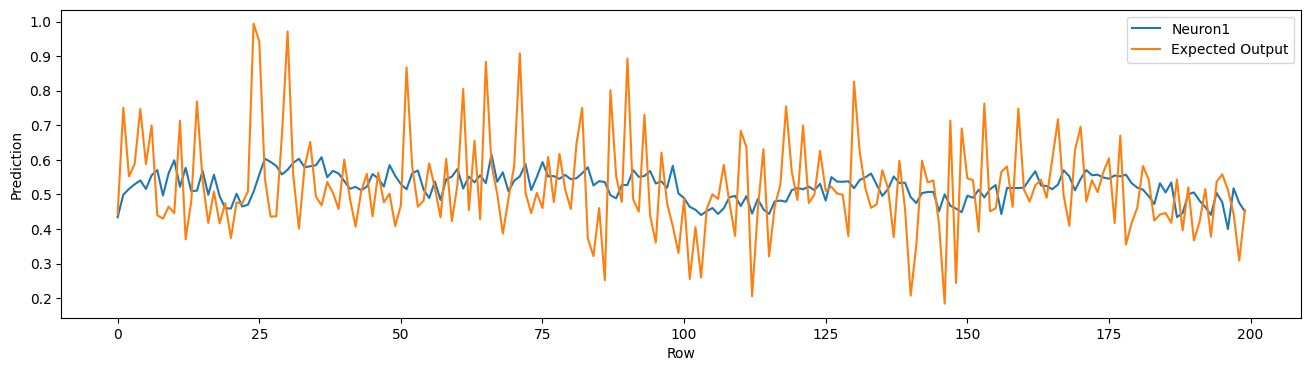

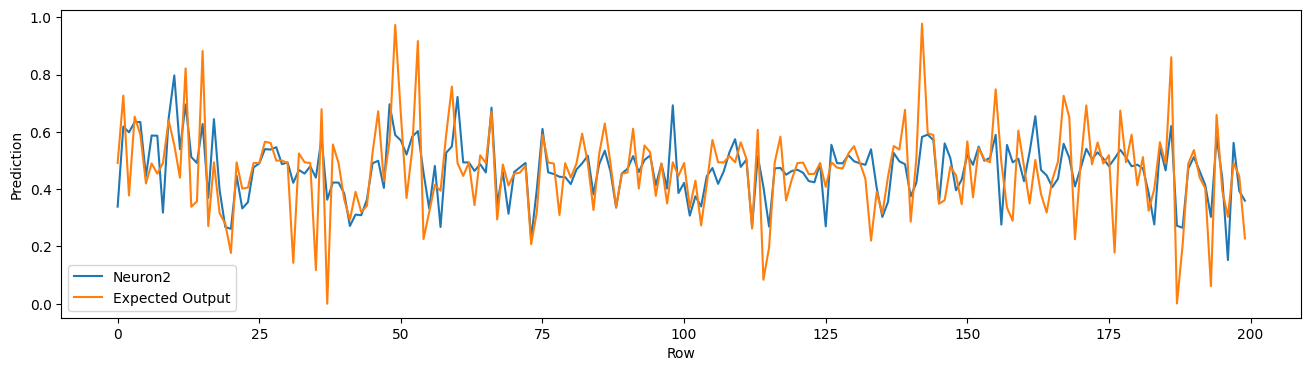

In [11]:
neuron1, neuron2, eo1, eo2, error1, error2 = [], [], [], [], [], []

for index, row in test_scaled[:200].iterrows():
    nn_input, desired_out = row[0:2], row[2:4]
    il, hl, ol = forward_prop(nn_input, il, hl, ol)
    neuron1.append(ol[0].activation_value)
    eo1.append(desired_out.iloc[0])
    neuron2.append(ol[1].activation_value)
    eo2.append(desired_out.iloc[1])
    error1.append(desired_out.iloc[0] - ol[0].activation_value)
    error2.append(desired_out.iloc[1] - ol[1].activation_value)
    il, hl, ol = backward_prop(nn_input, desired_out, il, hl, ol)

one = math.sqrt(((sum(error1)/len(error1)) - (sum(neuron1)/len(neuron1)))**2 / len(error1))
two = math.sqrt(((sum(error2)/len(error2)) - (sum(neuron2)/len(neuron2)))**2 / len(error1))
rmse = (one + two) / 2

print(f"Validation test set RMSE: {rmse}")

plt.figure(figsize=(16, 4))
plt.plot(neuron1, label='Neuron1')
plt.plot(eo1, label='Expected Output')
plt.xlabel('Row')
plt.ylabel('Prediction')
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(neuron2, label='Neuron2')
plt.plot(eo2, label='Expected Output')
plt.xlabel('Row')
plt.ylabel('Prediction')
plt.legend()
plt.show()

